In [7]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from probDE.car import car_init
from probDE.ibm import ibm_init
from probDE.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from probDE.cython.KalmanODE import KalmanODE as KalmanODE_blas
from probDE.tests.KalmanODE import KalmanODE
from KalmanODE_py import KalmanODE_py
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [8]:
%%cython
from libc.math cimport sin
cpdef ode_fun(double[::1] x, double t, tuple theta, double[::1] x_out):
    x_out[0] = sin(2*t) - x[0]
    return


In [9]:
import numba
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

numba_f = numba.jit(f)

In [96]:
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_obs = 1
n_deriv = [3]
n_deriv_prior = [4]
p = sum(n_deriv_prior)

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 80
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(x0, n_deriv, n_deriv_prior)
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

In [97]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit)
kalmanode.z_states = z_states
kalman_sim = kalmanode.solve(x0_state, W, mv=False, sim=True)

In [98]:
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
k_sim, k_mu, k_var = kalmanode_py.solve(x0_state, W, mv=True, sim=True)

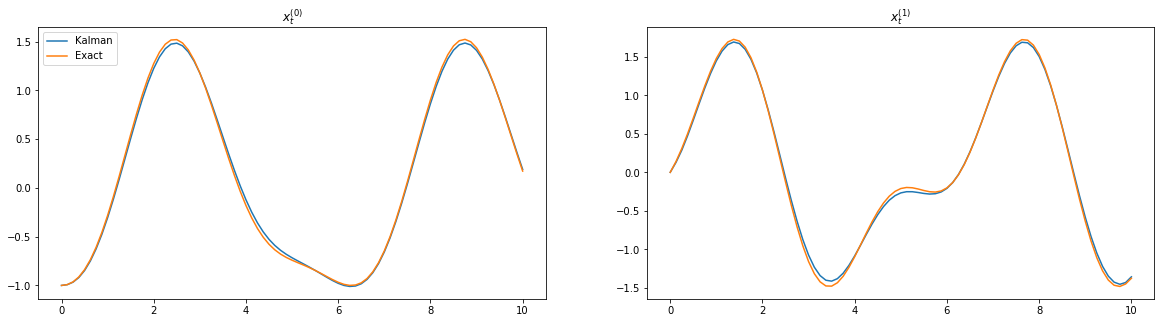

In [99]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, k_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, ode[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, k_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, ode[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [100]:
kalmanode = KalmanODE(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_c = %timeit -o _ = kalmanode.solve(x0_state, W, mv=False, sim=True)

442 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [105]:
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_cy = %timeit -o _ = kalmanode.solve(x0_state, W, mv=False, sim=True)

1.06 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, mv=False, sim=True)

11.1 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = %timeit -o ode = odeint(numba_f, [-1, 0], tseq)

510 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [106]:
print("Cython is {}x faster than Python".format(kalman_py.average/kalman_cy.average))
print("C++ is {}x faster than Python".format(kalman_py.average/kalman_c.average))
print("ode is {}x faster than Python".format(kalman_py.average/ode.average))

Cython is 10.417040277056982x faster than Python
C++ is 25.100766172449266x faster than Python
ode is 21.739100164747146x faster than Python


## Lorenz63

In [34]:
%%cython
# RHS of ODE
import numpy as np
cimport numpy as np
cpdef lorenz(double[::1] X, double t, tuple theta, out):
    rho, sigma, beta = theta
    cdef int p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return

In [35]:
def lorenz0(X, t, theta):
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

numba_lorenz = numba.jit(lorenz0)

In [125]:
# These parameters define the order of the ODE and the CAR(p) process
n_obs = 3
n_deriv = [2, 2, 2] # number of continuous derivatives of CAR(p) solution prior
n_deriv_prior = [3, 3, 3]
p = sum(n_deriv_prior)

# LHS Matrix of ODE
W_mat = np.zeros((len(n_deriv), sum(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+1] = 1

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 3000
tmin = 0
tmax = 20
theta = (28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([0.1, 1, 10])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
X0 = np.array([-12, 70, -5, 125, 38, -124/3])

In [126]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
W = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, W, theta)

In [127]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = odeint(numba_lorenz, x0, tseq, args=(theta,))

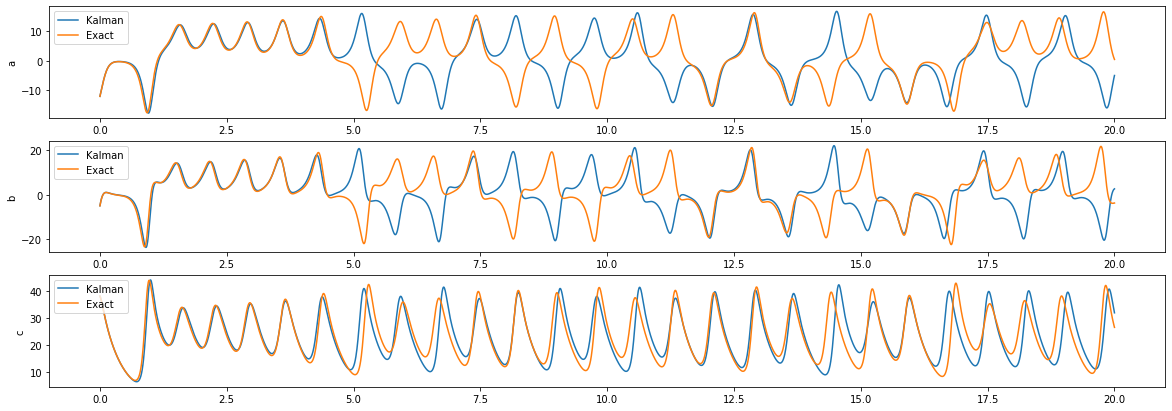

In [128]:
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_lor_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, ode_lorenz[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [129]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_lor_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
kalmanode.z_states = z_states
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = %timeit -o ode = odeint(numba_lorenz, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_lor_py.average/kalman_lor_cy.average))
print('py/c: {}'.format(kalman_lor_py.average/kalman_lor_c.average))
print('py/ode: {}'.format(kalman_lor_py.average/ode_lorenz.average))

370 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.1 ms ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.1 ms ± 488 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.73 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 7.850543656313531
py/c: 12.27639727599046
py/ode: 37.99592900934137


# Fitz model

In [130]:
%%cython
cpdef fitz(double[::1] X, double t, tuple theta, double[::1] X_out):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    cdef int n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    X_out[0] = c*(V - V**3/3 + R)
    X_out[1] = -1/c*(V - a + b*R)
    return

In [131]:
def fitz0(X, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    return c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)

numba_fitz = numba.jit(fitz0)

In [141]:
n_deriv = [2, 2] # Total state
n_deriv_prior = [3, 3]
p = sum(n_deriv_prior)
n_obs = 2 # Total measures
state_ind = [0, 3]

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
#h = 0.1 # step size
#n_eval = int((tmax-tmin)/h)
n_eval = 400

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
X0 = np.array([-1, 1, 1, 1/3])
w_mat = np.array([[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
theta = (0.2, 0.2, 3)


In [142]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, fitz, **kinit)
z_states = rand_mat(2*(n_eval+1), p)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_fitz_sim = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)

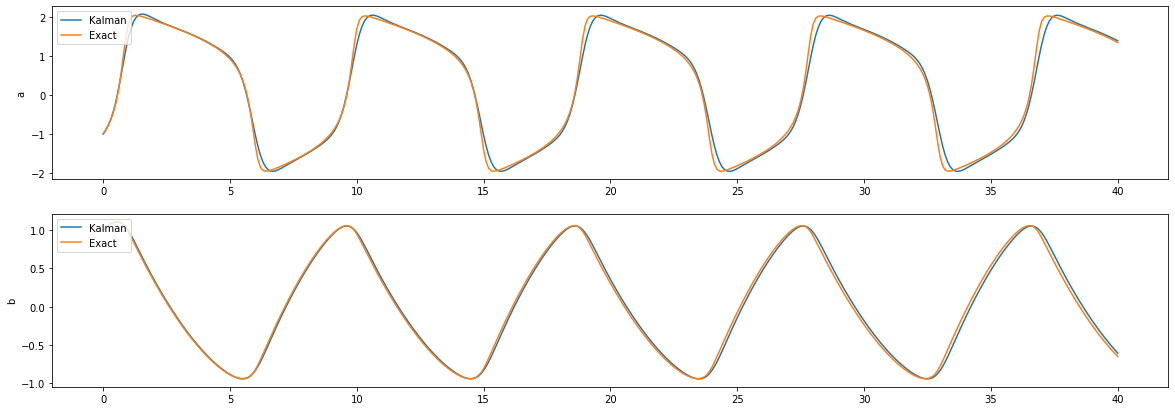

In [143]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz0, x0, tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_fitz_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [144]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_fitz_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_states = z_states
kalman_fitz_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_fitz_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_fitz = %timeit -o ode =  odeint(numba_fitz, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_fitz_py.average/kalman_fitz_cy.average))
print('py/c: {}'.format(kalman_fitz_py.average/kalman_fitz_c.average))
print('py/ode: {}'.format(kalman_fitz_py.average/ode_fitz.average))

2.82 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.3 ms ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.8 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.46 ms ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 9.00809030380265
py/c: 16.917232578688992
py/ode: 10.696841060913977


# MSEIR model

We will look at a multivariate ODE system called **MSEIR model**. This model is used in epidemiology where<br/>
M = Maternally-derived Immunity<br/>
S = Susceptible<br/>
E = Exposed<br/>
I = Infectious<br/>
R = Recovered<br/>

\begin{equation}
  \begin{aligned}
    \frac{dM}{dt} &= \Lambda - \delta M - \mu M \\
    \frac{dS}{dt} &= \delta M- \frac{\beta SI}{N} - \mu S \\
    \frac{dE}{dt} &= \frac{\beta SI}{N} - (\epsilon + \mu)E \\
    \frac{dI}{dt} &= \epsilon E - (\gamma + \mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R
  \end{aligned}
\end{equation}


In [79]:
%%cython
import numpy as np
cimport numpy as np
cpdef mseir(double[::1] X, double t, double[::1] theta, double[::1] X_out):
    cdef int p = len(X)//5
    M, S, E, I, R = X[::p]
    cdef double N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    X_out[0] = Lambda - delta*M - mu*M
    X_out[1] = delta*M - beta*S*I/N - mu*S
    X_out[2] = beta*S*I/N - (epsilon + mu)*E
    X_out[3] = epsilon*E - (gamma + mu)*I
    X_out[4] = gamma*I - mu*R
    return

In [80]:
def mseir0(X_t, t, theta):
    "MSEIR ODE function"
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    dM = Lambda - delta*M - mu*M
    dS = delta*M - beta*S*I/N - mu*S
    dE = beta*S*I/N - (epsilon + mu)*E
    dI = epsilon*E - (gamma + mu)*I
    dR = gamma*I - mu*R
    return np.array([dM, dS, dE, dI, dR])

numba_mseir = numba.jit(mseir0)

In [145]:
# LHS Matrix of ODE

n_deriv = [2]*5 # Total state
n_deriv_prior = [3]*5
p = sum(n_deriv_prior)
n_obs = 5 # Total measures
state_ind = [0, 3, 6, 9, 12]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0
tmax = 20
theta = np.array([1.1, 0.7, 0.4, 0.005, 0.02, 0.03])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 5
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, x0, for the IVP
W_mat = np.zeros((len(n_deriv), sum(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

x0 = np.array([1000, 100, 50, 3, 3])
v0 = mseir0(x0, 0, theta)
X0 = np.ravel([x0, v0], 'F')
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

In [146]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, mseir, **kinit)
# Run the solver to get an approximation
kalman_mse_sim = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)

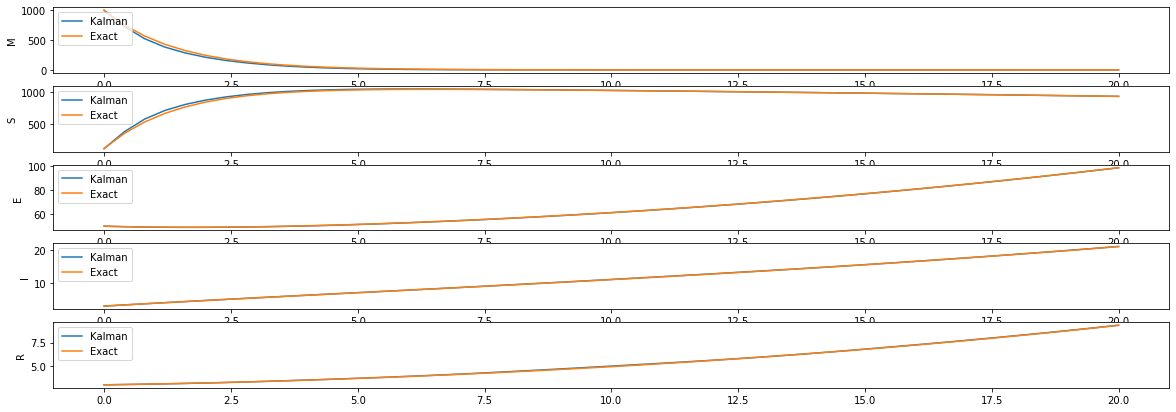

In [147]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(mseir0, x0, tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['M', 'S', 'E', 'I', 'R']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_mse_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [148]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_mse_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, mseir, **kinit)
kalmanode.z_states = z_states
kalman_mse_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_mse_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_mseir = %timeit -o ode =  odeint(numba_mseir, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_mse_py.average/kalman_mse_cy.average))
print('py/c: {}'.format(kalman_mse_py.average/kalman_mse_c.average))
print('py/ode: {}'.format(kalman_mse_py.average/ode_mseir.average))

1.35 ms ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.54 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.87 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
341 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
py/cy: 5.102098643994438
py/c: 5.8363589835264715
py/ode: 23.054136794404673
